# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection

from tools import utilityTools as utility
from tools import dataTools as dt
import pyaldata as pyal
import set_rc_params as set_rc


%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']
reload(dt)
reload(set_rc)

# Global params
set_rc.set_rc_params()
root = pathlib.Path("/data")

if "__file__" not in dir():

    BIN_SIZE = .03  # sec
    WINDOW_ctrl = (-.95, -.5)
    WINDOW_prep = (-.4, .05)  # sec
    WINDOW_exec = (-.05, .40)  # sec
    n_components = 10  # min between M1 and PMd
    areas = ('M1', 'Str')

    prep_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                         rel_start=int(WINDOW_prep[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_prep[1]/BIN_SIZE)
                                        )
    exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                         rel_start=int(WINDOW_exec[0]/BIN_SIZE),
                                         rel_end=int(WINDOW_exec[1]/BIN_SIZE)
                                        )
    exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_pull_off',
                                         rel_start=int(-WINDOW_exec[1]/BIN_SIZE),
                                         rel_end=int(-WINDOW_exec[0]/BIN_SIZE)
                                        )

    fixation_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on', 
                                             rel_start=int(WINDOW_ctrl[0]/BIN_SIZE),
                                             rel_end=int(WINDOW_ctrl[1]/BIN_SIZE)
                                            )

In [2]:
if "__file__" not in dir():

    def prep_general_mouse (df):
        "preprocessing general! for J. Dudman mouse data"
        # rename unit fields
        old_fields = [col for col in df.columns.values if 'unit' in col]
        new_fields = ['M1_spikes' if 'Ctx' in col else 'Str_spikes' for col in old_fields]
        df_ = df.rename(columns = {old:new for old,new in zip(old_fields,new_fields)})
        # change spikes datatype
        for signal in new_fields:
            df_[signal] = [np.nan_to_num(x=s.toarray().T, nan=0) for s in df_[signal]]
        # add trial_id
        df_['trial_id'] = np.arange(1,df_.shape[0]+1)
        # only keep good trials
        df_= pyal.select_trials(df_, df_.trialType== 'sp')
        # fill no-laser trials (and index fields) with zero
        n_bins = df_[new_fields[0]][0].shape[0]
        var_len_fields = [ 'spkPullIdx', 'spkRchIdx', 'spkTimeBlaserI']
        fill_zeros = lambda a: a if len(a)>1 else np.zeros((n_bins,))
        for field in var_len_fields:
            if field not in df_.columns:continue
            df_[field] = [fill_zeros(s) for s in df_[field]]
        # fill fields that are cut with np.nans and remove trials that are too long or don't exist
        cut_fields = ['hTrjB', 'hVelB']
        df_['badIndex'] = [max(trialT.shape)>n_bins or
                           max(trialV.shape)>n_bins or 
                           max(trialT.shape) < 2 or 
                           max(trialV.shape) < 2 or 
                           np.isnan(trialT).sum() > 5 for trialT,trialV in zip(df_.hTrjB,df_.hVelB)]
        df_= pyal.select_trials(df_, df_.badIndex == False)
        df_.drop('badIndex', axis=1, inplace=True)
        fill_nans = lambda a: a if max(a.shape)==n_bins else np.pad(a, ((0,n_bins-max(a.shape)),(0,0)), 'constant', constant_values=(np.nan,))
        for field in cut_fields:
            if field not in df_.columns:continue
            df_[field] = [fill_nans(s.T) for s in df_[field]]   
        # add bin_size
        df_['bin_size']=0.01  # data has 10ms bin size
        # add idx_movement_on which is exactly at t=df.timeAlign
        df_['idx_movement_on'] = [np.argmin(np.abs(s-i)) for i,s in zip(df_['timeAlign'],df_['spkTimeBins'])]
        # add pull start idx
        df_['idx_pull_on'] = [pullIdx.nonzero()[0][0] if len(pullIdx.nonzero()[0])>0 else np.nan for pullIdx in df_.spkPullIdx]
        # add pull stop idx
        df_['idx_pull_off'] = [pull.nonzero()[0][-1] for pull in df_.spkPullIdx]
        # remove trials with no pull idx
        df_.dropna(subset=['idx_pull_on'], inplace=True)
        df_.idx_pull_on = df_.idx_pull_on.astype(np.int32)
        df_.index = np.arange(df_.shape[0])
        # add target_id
        df_['target_id'] = np.remainder(df_['blNumber'].to_numpy(), 4)

        for signal in new_fields:
            df_ = pyal.remove_low_firing_neurons(df_, signal, 1)

        df_= pyal.select_trials(df_, df_.trialType== 'sp')
        try:
            noLaserIndex = [i for i,laserData in enumerate(df_.spkTimeBlaserI) if not np.any(laserData)]
            df_= pyal.select_trials(df_, noLaserIndex)
        except AttributeError:
            # due to absence of this field in no-laser sessions
            pass

        df_ = pyal.combine_time_bins(df_, int(BIN_SIZE/.01))
        for signal in new_fields:
            df_ = pyal.sqrt_transform_signal(df_, signal)

        df_= pyal.add_firing_rates(df_, 'smooth', std=0.05)

        return df_

# reading data

In [3]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

In [4]:
# load the DFs
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)

allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)

collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

## within mouse, within area, across epochs

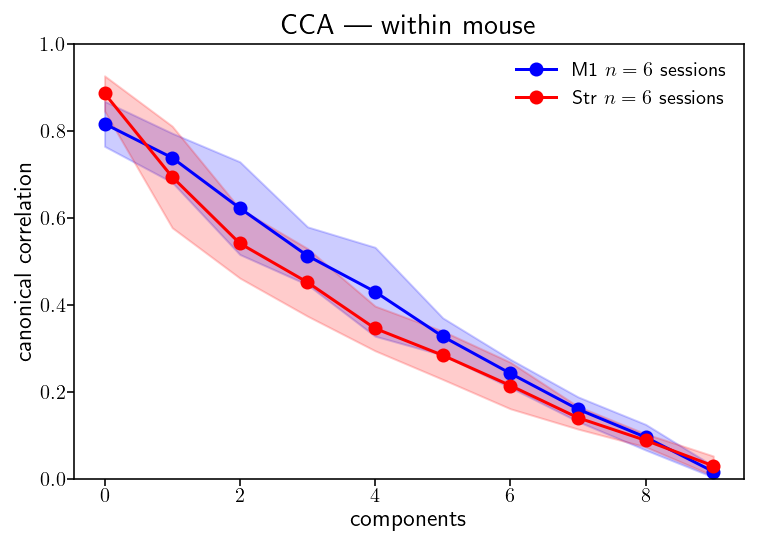

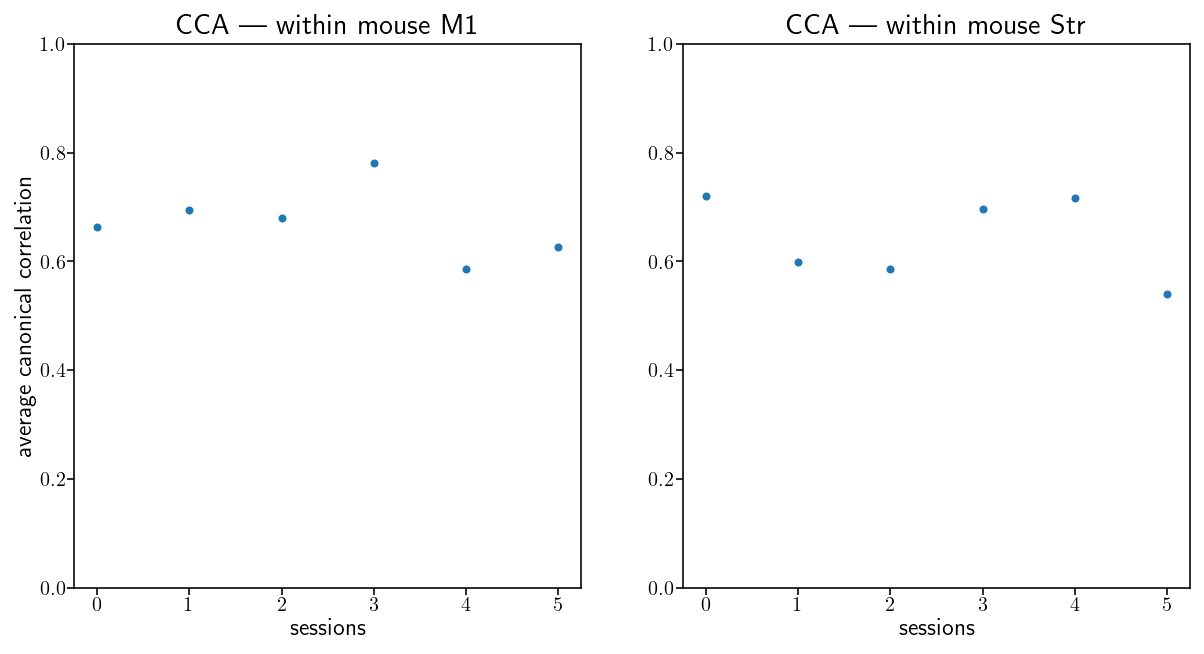

In [5]:
if "__file__" not in dir():

    warnings.filterwarnings("ignore")
    # M1
    AllData1 = dt.get_data_array(allDFs_M1, prep_epoch, area=areas[0], model=n_components)
    AllData1_ = dt.get_data_array(allDFs_M1, fixation_epoch, area=areas[0], model=n_components)
    _,_, min_trials1, min_time1,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)
    # Str
    AllData2 = dt.get_data_array(allDFs_Str, exec_epoch, area=areas[1], model=n_components)
    AllData2_ = dt.get_data_array(allDFs_Str, fixation_epoch, area=areas[1], model=n_components)
    _,_, min_trials2, min_time2,_ = np.min((AllData2.shape,AllData2_.shape),axis=0)

    warnings.filterwarnings("default")

    inCCs0=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        data1 = np.reshape(sessionData1[:,:min_trials1,:min_time1,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials1,:min_time1,:], (-1,n_components))
        inCCs0.append(dt.canoncorr(data1, data2))
    CC_lower_bound_M1 = np.array(inCCs0).T

    inCCs1=[]
    for sessionData1,sessionData2 in zip(AllData2,AllData2_):
        data1 = np.reshape(sessionData1[:,:min_trials2,:min_time2,:], (-1,n_components))
        data2 = np.reshape(sessionData2[:,:min_trials2,:min_time2,:], (-1,n_components))
        inCCs1.append(dt.canoncorr(data1, data2))
    CC_lower_bound_Str = np.array(inCCs1).T
    warnings.filterwarnings("default")

    if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
        print('variables: `CC_lower_bound_M1` and `CC_lower_bound_PMd` hold the lower bound correlations')
        del allDFs_M1, allDFs_PMd, side1df, side2df

# plotting
if "__file__" not in dir():
    _,ax = plt.subplots()

    utility.shaded_errorbar(ax, CC_lower_bound_M1, color='b', marker = 'o', label=f'{areas[0]} $n={CC_lower_bound_M1.shape[1]}$ sessions')
    utility.shaded_errorbar(ax, CC_lower_bound_Str, color='r', marker = 'o', label=f'{areas[1]} $n={CC_lower_bound_Str.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('components')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- within mouse');

    fig,axes = plt.subplots(ncols=2, figsize=(10,5))
    axes[0].plot(CC_lower_bound_M1[:4,:].mean(axis=0),'.')
    axes[1].plot(CC_lower_bound_Str[:4,:].mean(axis=0),'.')
    axes[0].set_ylabel('average canonical correlation')
    for i, ax in enumerate(axes):
        ax.set_title(f'CCA --- within mouse {areas[i]} ', usetex=True);
        ax.set_ylim([0,1])
        ax.set_xlabel('sessions')

## across mice, within area, across epochs, shuffled targets

so in short: different animals, different behaviours.

In [17]:
pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, df2 in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))


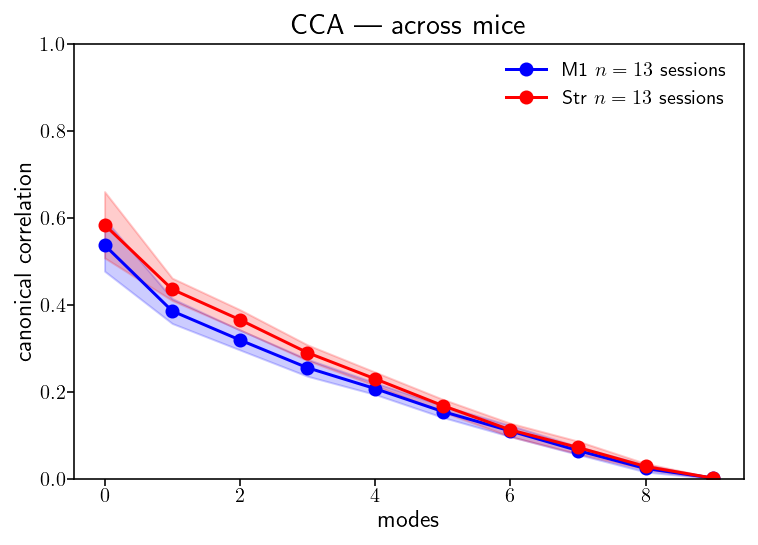

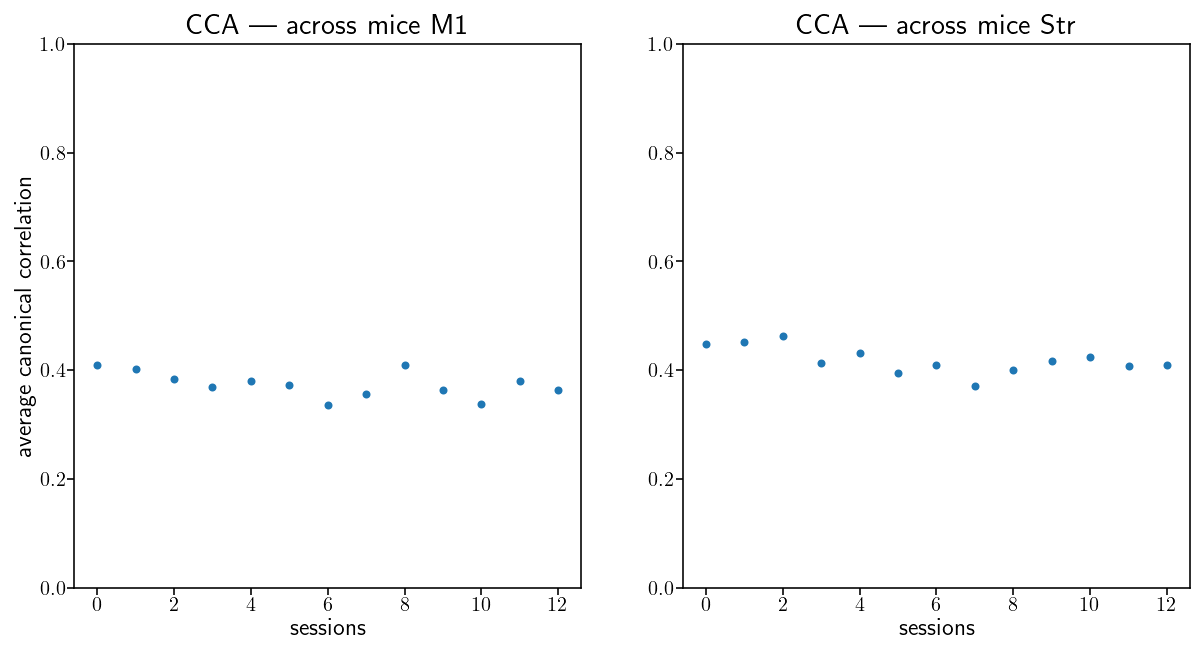

In [19]:
rng = np.random.default_rng(1)
n_iter = 1000

side1df = [allDFs_M1[i] for i,_ in pairFileList1]
side2df = [allDFs_M1[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, exec_epoch, area=areas[0], model=n_components)
AllData2 = dt.get_data_array(side2df, fixation_epoch, area=areas[0], model=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)

side1df = [allDFs_Str[i] for i,_ in pairFileList2]
side2df = [allDFs_Str[j] for _,j in pairFileList2]
AllData1_ = dt.get_data_array(side1df, exec_epoch, area=areas[1], model=n_components)
AllData2_ = dt.get_data_array(side2df, fixation_epoch, area=areas[1], model=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    r = []
    for n in range(n_iter):
        sessionData1_sh = rng.permutation(sessionData1,axis=0)
        sessionData2_sh = rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,n_components))
        r.append(dt.canoncorr(data1, data2))
    allCCs0.append(r)
allCCs0 = np.array(allCCs0)
CC_lower_bound_M1 = np.percentile(allCCs0, 1, axis=1).T


allCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = rng.permutation(sessionData1,axis=0)
        sessionData2_sh = rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials_,:min_time_,:], (-1,n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials_,:min_time_,:], (-1,n_components))
        r.append(dt.canoncorr(data1, data2))
    allCCs1.append(r)
allCCs1 = np.array(allCCs1)
CC_lower_bound_Str = np.percentile(allCCs1, 1, axis=1).T



if "__file__" in dir():  # runs when the notebook is being `imported` from another notebook
    print('variables: `CC_lower_bound_M1` and `CC_lower_bound_Str` hold the lower bound correlations')

if "__file__" not in dir():
    # plot
    _,ax = plt.subplots()
    utility.shaded_errorbar(ax, CC_lower_bound_M1, color='b', marker = 'o', label=f'{areas[0]} $n={CC_lower_bound_M1.shape[1]}$ sessions')
    utility.shaded_errorbar(ax, CC_lower_bound_Str, color='r', marker = 'o', label=f'{areas[1]} $n={CC_lower_bound_Str.shape[1]}$ sessions')
    ax.set_ylim([0,1])
    ax.set_xlabel('modes')
    ax.legend()
    ax.set_ylabel('canonical correlation')
    ax.set_title('CCA --- across mice', usetex=True);

    _,axes = plt.subplots(ncols=2, figsize=(10,5))
    axes[0].plot(CC_lower_bound_M1[:4,:].mean(axis=0),'.')
    axes[1].plot(CC_lower_bound_Str[:4,:].mean(axis=0),'.')
    axes[0].set_ylabel('average canonical correlation')
    for i, ax in enumerate(axes):
        ax.set_title(f'CCA --- across mice {areas[i]} ');
        ax.set_ylim([0,1])
        ax.set_xlabel('sessions')
